In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import nltk
nltk.download('punkt')
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from tqdm import tqdm

[nltk_data] Downloading package punkt to /home/pk36/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## CatE Helper Functions ##

In [2]:
def readCateEmbeddings(filename):
    emb = {}
    with open(filename, 'r') as infile:
        vectors = infile.readlines()[1:]
        for v in vectors:
            token,cate_emb = v.strip().split(' ', 1)
            cate_emb = cate_emb.split(' ')
            emb[token] = np.array(cate_emb)
            emb[token] = emb[token].astype(np.float64)
    return emb

In [3]:
def readCateSpec(filename):
    spec = {}
    with open(filename, 'r') as infile:
        temp = infile.readlines()[1:]
        for s in temp:
            token,specificity = s.strip().split(' ')
            spec[token] = float(specificity)
    return spec

## Compute Reciprocal Entropy Per Word Over Doc and Corpus ##

In [4]:
def tf_idf(df):
    numdoc = df.groupby(by="words").size()
    metric = []
    print("Computing tf-idf...")
    for i, token in enumerate(tqdm(df["words"].values)):
        metric.extend([df["count"].values[i] * np.log(len(corpus)/float(numdoc.loc[token]))])
        
    df["tf_idf"] = metric
    return df

In [5]:
def calcRecEntropy(corpus):
    ent_df = pd.DataFrame()
    w = [] # word
    c = [] # count
    p = [] # probability within doc
    # dataframe w/ words and count for each document
    for doc in tqdm(corpus):
        data = nltk.word_tokenize(doc) 
        counter = Counter(data)
        df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
        df = df.rename(columns={"index": "words", 0: "count"})
        w.extend(df["words"].values)
        c.extend(df["count"].values)
        p.extend(df["count"].values/float(len(data)))
    
    ent_df["words"] = w
    ent_df["count"] = c
    ent_df["doc_prob"] = p
    ent_df["num_docs"] = np.ones(len(ent_df))
    # compute tf-idf for each of the words and average for each unique word
    ent_df = tf_idf(ent_df)
    # compute entropy & reciprocal entropy
    ent_df = ent_df.groupby(by="words").agg({'count' : 'sum', 'doc_prob' : 'mean', 'tf_idf' : 'mean'})
    ent_df["prob"] = ent_df['count'] / float(len(w)) # probability across entire corpus
    
    ent_df["entropy"] = (ent_df["prob"]*np.log(1/ent_df["prob"]))
    ent_df['reciprocal_entropy'] = 1/ent_df["entropy"]
    
    ent_df["doc_entropy"] = (ent_df["doc_prob"]*np.log(1/ent_df["doc_prob"]))
    ent_df['doc_rep_entropy'] = 1/ent_df["doc_entropy"]
    
    return ent_df

In [6]:
corpus = []
with open('/shared/data2/pk36/multidim/cate_data/nyt/phrase_text.txt') as infile:
    corpus = list(infile.readlines())

In [7]:
ent_df = calcRecEntropy(corpus)

100%|████████████████████████████████████| 31997/31997 [02:43<00:00, 196.04it/s]


Computing tf-idf...


100%|████████████████████████████| 10055455/10055455 [02:28<00:00, 67507.50it/s]


In [8]:
ent_df

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
!,2100,0.001585,5.720918,2.088419e-04,0.001770,565.063683,0.010218,97.867046
',30150,0.002411,1.835597,2.998373e-03,0.017420,57.406594,0.014533,68.808458
'',40051,0.003099,2.577832,3.983012e-03,0.022009,45.435962,0.017900,55.865693
''100,1,0.000470,10.373397,9.944851e-08,0.000002,623647.255600,0.003604,277.473333
''1951,1,0.000903,10.373397,9.944851e-08,0.000002,623647.255600,0.006327,158.052883
...,...,...,...,...,...,...,...,...
zypries,1,0.001221,10.373397,9.944851e-08,0.000002,623647.255600,0.008191,122.091493
zyskind,4,0.002378,41.493590,3.977940e-07,0.000006,170577.947242,0.014367,69.602560
zyuganov,58,0.003017,15.203649,5.768013e-06,0.000070,14371.821796,0.017507,57.120019


## Top Words w/ Highest Reciprocal Entropy (expected more rare) ##

In [9]:
ent_df.sort_values(by="reciprocal_entropy", ascending = False).head(10)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
jnr,1,0.000517,10.373397,9.944851e-08,0.000002,623647.2556,0.003913,255.571779
neuve,1,0.001007,10.373397,9.944851e-08,0.000002,623647.2556,0.006949,143.897806
neven,1,0.000587,10.373397,9.944851e-08,0.000002,623647.2556,0.004369,228.893337
neveloff,1,0.000953,10.373397,9.944851e-08,0.000002,623647.2556,0.006631,150.813893
coranna,1,0.000685,10.373397,9.944851e-08,0.000002,623647.2556,0.004991,200.379026
coraopolis,1,0.008197,10.373397,9.944851e-08,0.000002,623647.2556,0.039377,25.395392
nevas,1,0.000397,10.373397,9.944851e-08,0.000002,623647.2556,0.003112,321.310759
nevadans,1,0.001005,10.373397,9.944851e-08,0.000002,623647.2556,0.006937,144.145601
corbaz,1,0.001006,10.373397,9.944851e-08,0.000002,623647.2556,0.006943,144.021711


In [10]:
ent_df.sort_values(by="doc_rep_entropy", ascending = False).head(10)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
pene,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
errico,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
exerpts,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
tanguardia,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
ligeti,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
lifehouse,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
libro,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
tartuffe,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435
levittpavilion,1,0.000029,10.373397,9.944851e-08,0.000002,623647.2556,0.000302,3314.215435


## Bottom Words w/ Lowest Reciprocal Entropy (expected less rare) ##

In [11]:
ent_df.sort_values(by="reciprocal_entropy", ascending = True).head(15)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
the,1441053,0.059229,0.185526,0.143311,0.278415,3.591756,0.167401,5.973674
",",1431049,0.058223,0.216820,0.142316,0.277474,3.603942,0.165556,6.040249
.,1295743,0.053955,0.022800,0.128860,0.264038,3.787340,0.157527,6.348137
of,619385,0.025691,0.607250,0.061597,0.171679,5.824809,0.094072,10.630194
to,595034,0.024255,1.295138,0.059175,0.167303,5.977167,0.090207,11.085646
a,528390,0.021892,1.160112,0.052548,0.154807,6.459652,0.083662,11.952840
in,497585,0.021427,0.839729,0.049484,0.148754,6.722494,0.082345,12.144030
and,495569,0.019611,1.666377,0.049284,0.148352,6.740738,0.077105,12.969283
``,324995,0.013753,3.853091,0.032320,0.110925,9.015090,0.058951,16.963116


In [12]:
ent_df.sort_values(by="doc_rep_entropy", ascending = True).head(15)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
the,1441053,0.059229,0.185526,1.433106e-01,0.278415,3.591756,0.167401,5.973674
",",1431049,0.058223,0.216820,1.423157e-01,0.277474,3.603942,0.165556,6.040249
.,1295743,0.053955,0.022800,1.288597e-01,0.264038,3.787340,0.157527,6.348137
tsutako,2,0.047619,20.746795,1.988970e-07,0.000003,325830.948852,0.144977,6.897634
eurobell,3,0.047619,31.120192,2.983455e-07,0.000004,223082.549898,0.144977,6.897634
geipan,2,0.045455,20.746795,1.988970e-07,0.000003,325830.948852,0.140502,7.117340
umemployment,2,0.044444,20.746795,1.988970e-07,0.000003,325830.948852,0.138378,7.226558
selenia,5,0.043478,51.866987,4.972425e-07,0.000007,138560.352894,0.136326,7.335367
nortey,3,0.043478,31.120192,2.983455e-07,0.000004,223082.549898,0.136326,7.335367


## Comparing Terms with High vs. Low TF-IDF Scores ##

In [15]:
ent_df.sort_values(by="tf_idf", ascending = False).head(20) # most of these are in Italian.
# they were, also, state, in, they have, etc...

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
p.r.c,300,0.006380,525.837571,0.000030,0.000311,3216.764608,0.032249,31.009149
kircher,43,0.026092,446.056089,0.000004,0.000053,18916.011799,0.095135,10.511340
jardines,41,0.016426,425.309295,0.000004,0.000051,19762.605759,0.067494,14.816241
verlan,40,0.019980,414.935897,0.000004,0.000049,20216.445706,0.078182,12.790624
jantzen,38,0.018078,394.189102,0.000004,0.000047,21193.047900,0.072548,13.783948
moosawi,37,0.009603,383.815705,0.000004,0.000046,21719.443611,0.044612,22.415432
kamaz,37,0.018335,383.815705,0.000004,0.000046,21719.443611,0.073321,13.638735
aqeelah,37,0.004313,383.815705,0.000004,0.000046,21719.443611,0.023488,42.574050
summerhill,33,0.010898,342.322115,0.000003,0.000041,24131.456684,0.049251,20.304167


In [14]:
ent_df.sort_values(by="tf_idf", ascending = True).head(10)

,count,doc_prob,tf_idf,prob,entropy,reciprocal_entropy,doc_entropy,doc_rep_entropy
words,,,,,,,,
.,1295743,0.053955,0.022800,0.128860,0.264038,3.787340,0.157527,6.348137
the,1441053,0.059229,0.185526,0.143311,0.278415,3.591756,0.167401,5.973674
",",1431049,0.058223,0.216820,0.142316,0.277474,3.603942,0.165556,6.040249
of,619385,0.025691,0.607250,0.061597,0.171679,5.824809,0.094072,10.630194
in,497585,0.021427,0.839729,0.049484,0.148754,6.722494,0.082345,12.144030
from,99921,0.005649,1.005726,0.009937,0.045824,21.822456,0.029241,34.198397
by,117774,0.006076,1.020445,0.011712,0.052086,19.198845,0.031009,32.248881
an,92566,0.005082,1.062238,0.009206,0.043155,23.172206,0.026842,37.255151
on,170700,0.008383,1.073547,0.016976,0.069193,14.452334,0.040084,24.947443


In [16]:
ent_df["tf_idf"].describe()

count    154082.000000
mean         13.043168
std          13.262826
min           0.022800
25%           8.987103
50%          10.373397
75%          10.373397
max         525.837571
Name: tf_idf, dtype: float64

## Compute Discriminative Scores ##

In [ ]:
ent_df[ent_df[""]]
# take emb_w (each word)

## Compute Sentence Embeddings ##

In [102]:
def getSentenceEmb(text, emb_w, entropy):
    res = None
    for word in text:
        word = word.strip()
        if word not in entropy or word not in emb_w:
            continue
        if res is None:
            res = np.array([0.0] * len(emb_w[word]))
        res = np.add(res, np.array(entropy[word] * emb_w[word]))
    return len(text), res

In [18]:
doc_length = [len(d) for d in corpus]
print(min(doc_length), np.mean(doc_length), max(doc_length))

9 4275.922648998344 169700


In [106]:
def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))
def getGeoMean(sentenceEmb, topicEmbs, length):
    n = max(1, len(topicEmbs))
    temp = cos_sim(sentenceEmb, topicEmbs[0])
    for x in topicEmbs[1:]:
        temp *= cos_sim(sentenceEmb, x)
    # add a bias penality term for short documents in a corpus with on average long documents
    return np.power(np.abs(temp), (1/n)) + np.log(length/np.mean(doc_length))

In [104]:
def getRankings(query, corpus, emb_w, emb_t, entropy, filename=None):
    res = []
    qTopics = []
    for x in query:
        qTopics.append(emb_t[x])
    for i, x in enumerate(tqdm(corpus)):
        length, s = getSentenceEmb(x.split(' '), emb_w, entropy)
        res.append((getGeoMean(s, qTopics, length), x))
    if filename is not None:
        with open(filename, 'w') as outfile:
            for x in res:
                outfile.write(str(x[0]) + '\t' + str(x[1]) + '\n')

# Load CatE Embeddings

In [24]:
folder = '/shared/data2/pk36/multidim/cate_data/nyt/'
emb_loc = readCateEmbeddings(folder + 'emb_locations_w.txt')

In [25]:
topicEmbeddings = {}
topicEmbeddings.update(readCateEmbeddings(folder + 'emb_locations_t.txt'))
#topicEmbeddings.update(readCateEmbeddings(folder + 'emb_virus_t.txt'))
#topicEmbeddings.update(readCateEmbeddings(folder + 'emb_study_t.txt'))
topicEmbeddings.keys()

dict_keys(['united_states', 'iraq', 'japan', 'china', 'britain', 'russia', 'germany', 'canada', 'france', 'italy'])

# Get Document Rankings

In [28]:
entropy = ent_df["tf_idf"].to_dict()
entropy

{'!': 5.7209176770667876,
 "'": 1.8355966155242396,
 "''": 2.5778318009314534,
 "''100": 10.373397427387058,
 "''1951": 10.373397427387058,
 "''1970": 10.373397427387058,
 "''2001": 10.373397427387058,
 "''2002": 10.373397427387058,
 "''2101": 10.373397427387058,
 "''31st": 10.373397427387058,
 "''34": 10.373397427387058,
 "''344th": 10.373397427387058,
 "''50": 10.373397427387058,
 "''60": 10.373397427387058,
 "''80": 10.373397427387058,
 "''88": 9.680250246827113,
 "''aaron": 10.373397427387058,
 "''abbas": 10.373397427387058,
 "''abc_news": 10.373397427387058,
 "''abe": 10.373397427387058,
 "''abortion": 8.763959514952957,
 "''about": 7.154521602518858,
 "''above": 8.427487278331744,
 "''abraham_lincoln": 9.680250246827113,
 "''abramovich": 9.274785138718947,
 "''abrupt": 10.373397427387058,
 "''absolute": 10.373397427387058,
 "''absolutely": 8.115431669216374,
 "''absorption": 10.373397427387058,
 "''abstention": 10.373397427387058,
 "''absurd": 10.373397427387058,
 "''abu_ghraib":

In [107]:
qTest = ["japan", "united_states"]
fname_result = "japan_us_tf_idf.txt"
getRankings(qTest, corpus, emb_loc, topicEmbeddings, entropy, fname_result)

100%|████████████████████████████████████| 31997/31997 [02:06<00:00, 253.70it/s]


In [108]:
rankings = []
with open(fname_result, 'r') as infile:
    for line in tqdm(infile.readlines()):
        if line == "\n":
            continue
        score, text = line.split('\t', 1)
        rankings.append((float(score), text))

100%|█████████████████████████████████| 63994/63994 [00:00<00:00, 629776.91it/s]


In [109]:
rankings = sorted(rankings, key=lambda x: x[0], reverse=True)

In [99]:
rankings[:5] # BEFORE doc length penalty

[(4.376911464059821,
  "lead japan is disappointed at recent threats of trade retaliation from the european_community just as the situation is improving , hajime_tamura , the japanese trade minister , said today . japan is disappointed at recent threats of trade retaliation from the european_community just as the situation is improving , hajime_tamura , the japanese trade minister , said today . ''i am deeply concerned that the e.c . has moved to take a harsher line toward japan despite this tangible improvement , '' mr . tamura added in a speech . he said that japanese imports of manufactured_goods from the community rose 55 percent in the 12 months ended march 31 . but european imports of japanese goods are expanding at a similar rate and from a larger base , so the japanese trade surplus is growing .\n"),
 (4.362863252252838,
  "lead japan moved today to increase penalties for illegal exports to communist countries . american anger continues over the toshiba machine company 's sales

In [27]:
qTopics = []
for x in qTest:
    qTopics.append(topicEmbeddings[x])

In [29]:
def getAttentionWeights(text, emb_w, topicEmbs):
    res = []
    for x in topicEmbs:
        temp = []
        for word in text:
            if word not in emb_w:
                continue
            temp.append(cos_sim(emb_w[word], x))
        res.append(temp)
    return res

In [30]:
text = ["children hospitalized with upper and or lower respiratory_tract symptoms and or signs of rti"]
res = []
for i, x in enumerate(corpus):
    res.append((getAttentionWeights(text[0].split(' '), emb_age, qTopics), x))

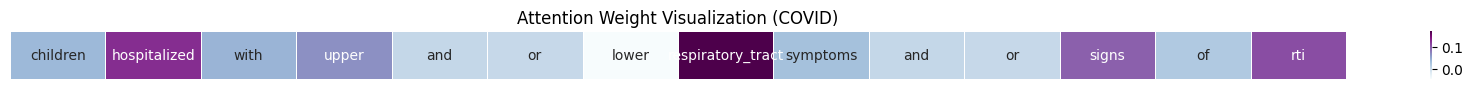

In [31]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][0]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(title='Attention Weight Visualization (COVID)')
ax.set(yticklabels=[])
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

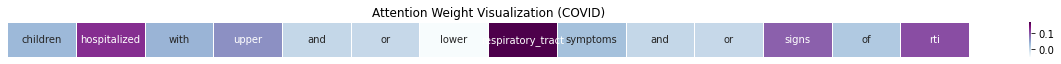

In [88]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][0]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(title='Attention Weight Visualization (COVID)')
ax.set(yticklabels=[])
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

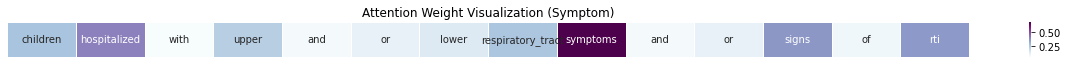

In [89]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][1]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(yticklabels=[])
ax.set(title='Attention Weight Visualization (Symptom)')
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

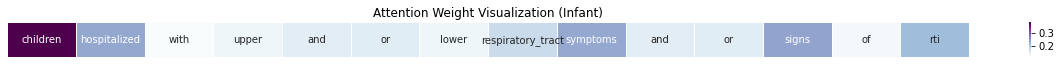

In [90]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][2]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(yticklabels=[])
ax.set(title='Attention Weight Visualization (Infant)')
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()